In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/Users/richard/Desktop/TF_2_Notebooks_and_Data/DATA/RSCCASN.csv',index_col='DATE',parse_dates=True)

In [3]:
df

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [4]:
df.columns = ['Sales']

<AxesSubplot:xlabel='DATE'>

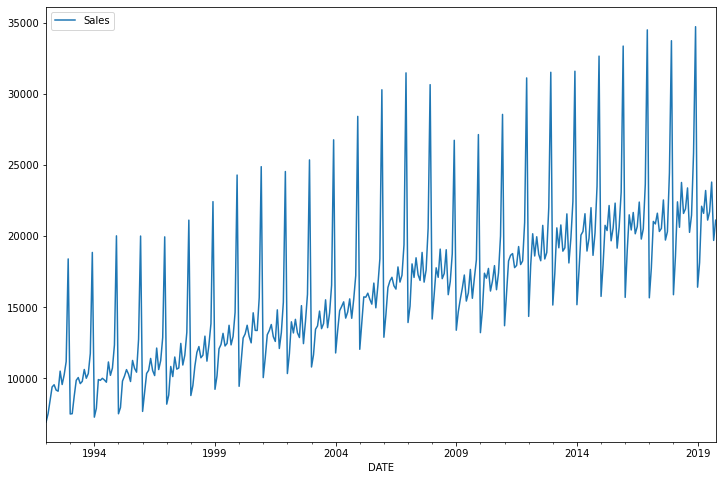

In [5]:
df.plot(figsize=(12,8))

In [9]:
test_ind = len(df)-18

In [10]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [11]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [12]:
test

,Sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260
2018-10-01,21473
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410


In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler = MinMaxScaler()

In [15]:
scaled_train = scaler.fit_transform(train)

In [16]:
scaled_test = scaler.transform(test)

In [17]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [18]:
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [27]:
X,y = generator[0]
X

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

In [22]:
n_features = 1
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [28]:
from tensorflow.keras.callbacks import EarlyStopping

In [29]:
early = EarlyStopping(monitor='val_loss',patience=2)

In [30]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test,length=length,batch_size=1)

In [57]:
validation_generator[5]

(array([[[0.52770113],
         [0.68592071],
         [1.00813244],
         [0.34388615],
         [0.40647691],
         [0.55021057],
         [0.53220302],
         [0.59040081],
         [0.51499419],
         [0.53645077],
         [0.61185739],
         [0.46314987]]]),
 array([[0.51463114]]))

In [32]:
model.fit(generator,epochs=20,callbacks=early,validation_data=validation_generator)

Epoch 1/20
304/304 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 2/20
304/304 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0027
Epoch 3/20
304/304 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 8.2306e-04
Epoch 4/20
304/304 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 2.5169e-04
Epoch 5/20
304/304 [==============================] - 1s 2ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 6/20
304/304 [==============================] - 1s 2ms/step - loss: 0.0012 - val_loss: 0.0019


<AxesSubplot:>

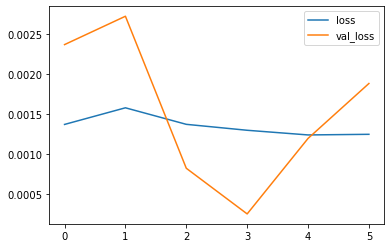

In [34]:
pd.DataFrame(model.history.history).plot()

In [58]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [59]:
preds = scaler.inverse_transform(test_predictions)

In [60]:
test['Predictions'] = preds

<ipython-input-60-3f875448906a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = preds


In [61]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,22351.210200
2018-06-01,21589,21340.734211
2018-07-01,21919,21547.660423
2018-08-01,23381,23131.107279
2018-09-01,20260,20968.134047
2018-10-01,21473,21486.536417
2018-11-01,25831,24872.058737
2018-12-01,34706,33225.222059
2019-01-01,16410,17465.252845


<AxesSubplot:xlabel='DATE'>

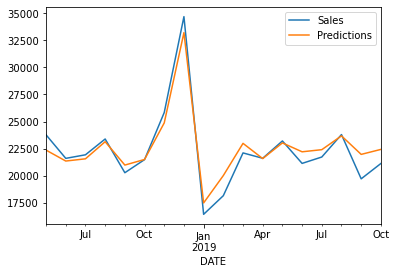

In [62]:
test.plot()

In [63]:
from sklearn.metrics import mean_squared_error

In [64]:
mean_squared_error(test['Sales'],test['Predictions'],squared=False)

1046.6459863409614

In [65]:
test['Sales'].mean()

22321.833333333332